# Heart Failure Readmission Prediction Models

This notebook builds and evaluates machine learning models to predict 30-day readmissions for heart failure patients.

## Goals:
1. Train multiple model types (Logistic Regression, Random Forest, XGBoost)
2. Compare model performance using appropriate metrics
3. Analyze feature importance
4. Save the best performing model

In [24]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import shap

# Add the src directory to Python path
notebook_dir = Path(r'c:/Users/tyagi/Desktop/heartbyte/notebooks')
src_dir = notebook_dir.parent / 'src'
sys.path.append(str(src_dir))

from data_loader import MIMICDataLoader
from data_processing import preprocess_features, prepare_model_data, calculate_readmissions, clean_features_for_modeling
from modeling import (
    train_logistic_regression, train_random_forest, train_xgboost,
    evaluate_model, plot_model_evaluation, save_model, 
    explain_model_with_shap, plot_shap_dependence
)

# Configure plotting
%matplotlib inline
plt.style.use('default')
sns.set_theme()

## 1. Load and Preprocess Data

First, we'll load the heart failure patient data and preprocess it for modeling.

In [25]:
# Load heart failure patient data
loader = MIMICDataLoader()
loader.load_data()
hf_patients, hf_admissions, hf_diagnoses, hf_procedures = loader.filter_heart_failure_patients()

# Calculate readmissions
hf_admissions = calculate_readmissions(hf_admissions)

# Create feature dataset (from 02_data_analysis.ipynb)
def create_features(patients, admissions, diagnoses, procedures):
    # Start with admissions data
    features = admissions.copy()
    
    # Add patient demographics and calculate age
    patient_features = patients[['subject_id']].copy()
    
    # Add gender if available
    if 'gender' in patients.columns:
        patient_features['gender'] = patients['gender']
        features = features.merge(patient_features[['subject_id', 'gender']], 
                                on='subject_id', 
                                how='left')
    
    # Calculate age if DOB is available
    if 'dob' in patients.columns and 'admittime' in admissions.columns:
        # Convert dates to datetime
        patient_features['dob'] = pd.to_datetime(patients['dob'])
        features['admittime'] = pd.to_datetime(features['admittime'])
        
        # Calculate age using year difference then adjust for month and day
        features = features.merge(patient_features[['subject_id', 'dob']], 
                                on='subject_id', 
                                how='left')
        features['age'] = features.apply(lambda x: 
            (x['admittime'].year - x['dob'].year) - 
            ((x['admittime'].month, x['admittime'].day) < 
             (x['dob'].month, x['dob'].day)), axis=1)
        
        # Drop temporary DOB column
        features = features.drop('dob', axis=1)
    
    # Calculate length of stay if discharge time is available
    if 'dischtime' in features.columns:
        features['dischtime'] = pd.to_datetime(features['dischtime'])
        features['length_of_stay'] = (features['dischtime'] - 
                                     features['admittime']).dt.total_seconds() / (24*60*60)
    
    # Calculate admission count and time since last admission
    features['admission_count'] = features.groupby('subject_id').cumcount() + 1
    
    if 'dischtime' in features.columns:
        features['prev_dischtime'] = features.groupby('subject_id')['dischtime'].shift(1)
        features['days_since_last_admission'] = (features['admittime'] - 
                                                pd.to_datetime(features['prev_dischtime'])).dt.total_seconds() / (24*60*60)
    
    # Count comorbidities per admission
    if 'hadm_id' in diagnoses.columns:
        comorbidity_counts = diagnoses.groupby('hadm_id').size().reset_index(name='num_diagnoses')
        features = features.merge(comorbidity_counts, on='hadm_id', how='left')
    
    # Count procedures per admission if available
    if procedures is not None and 'hadm_id' in procedures.columns:
        procedure_counts = procedures.groupby('hadm_id').size().reset_index(name='num_procedures')
        features = features.merge(procedure_counts, on='hadm_id', how='left')
    
    # Fill missing values
    numerical_columns = ['length_of_stay', 'days_since_last_admission', 'num_diagnoses', 'num_procedures']
    for col in numerical_columns:
        if col in features.columns:
            features[col] = features[col].fillna(0)
    
    return features

# Create feature dataset
features_df = create_features(hf_patients, hf_admissions, hf_diagnoses, hf_procedures)

# Clean features by removing datetime and non-numeric columns
# Use the module function from data_processing
features_df_clean = clean_features_for_modeling(features_df)

# Print info about the cleaning process
datetime_cols = [col for col in features_df.columns if pd.api.types.is_datetime64_any_dtype(features_df[col])]
object_cols = [col for col in features_df.columns if pd.api.types.is_object_dtype(features_df[col])]
other_non_numeric = [col for col in features_df.columns if not pd.api.types.is_numeric_dtype(features_df[col]) 
                    and col not in datetime_cols and col not in object_cols]

if datetime_cols:
    print(f"Removed datetime columns: {datetime_cols}")
if object_cols:
    print(f"Removed object columns: {object_cols}")
if other_non_numeric:
    print(f"Removed other non-numeric columns: {other_non_numeric}")

# Display the columns that remained after cleaning
print(f"\nRemaining features after cleaning: {features_df_clean.shape[1]}")
print(f"Feature columns: {features_df_clean.columns.tolist()}")

# Prepare data for modeling using the cleaned features
X_train, X_test, y_train, y_test = prepare_model_data(
    features_df_clean, 
    target_col='is_readmission', 
    test_size=0.2, 
    random_state=42
)

# Display basic information
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
print(f"Class distribution in training set: \n{y_train.value_counts(normalize=True).round(3)}")

Loaded 58976 admissions
Loaded 46520 patients
Loaded 651047 diagnoses
Loaded 240095 procedures
Found 78963 procedures for heart failure patients
Found 10272 patients with heart failure
These patients had 16756 admissions
Removed datetime columns: ['admittime', 'dischtime', 'next_admittime', 'prev_dischtime']
Removed object columns: ['deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'gender']

Remaining features after cleaning: 13
Feature columns: ['row_id', 'subject_id', 'hadm_id', 'hospital_expire_flag', 'has_chartevents_data', 'days_to_next_admission', 'is_readmission', 'age', 'length_of_stay', 'admission_count', 'days_since_last_admission', 'num_diagnoses', 'num_procedures']
Training set: (13404, 12), Testing set: (3352, 12)
Class distribution in training set: 
is_readmission
0    0.902
1    0.098
Name: proportion, dtype: float64


## 2. Train and Evaluate Models

We'll train three models with different complexity levels:
1. Logistic Regression (baseline)
2. Random Forest
3. XGBoost

In [26]:
# Get feature names for importance analysis
feature_names = X_train.columns.tolist()

# Dictionary to store results
results = {}

# Check for NaN values in training and testing data
print("NaN check in training data:")
print(f"X_train contains NaN: {X_train.isna().any().any()}")
print(f"y_train contains NaN: {y_train.isna().any()}")
print("\nNaN check in testing data:")
print(f"X_test contains NaN: {X_test.isna().any().any()}")
print(f"y_test contains NaN: {y_test.isna().any()}")

if X_train.isna().any().any():
    print("\nFixing NaN values in training data...")
    # Count NaN values in each column
    nan_counts = X_train.isna().sum()
    cols_with_nan = nan_counts[nan_counts > 0]
    print(f"Columns with NaN values:\n{cols_with_nan}")
    
    # Fill NaNs with column means
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    
    # Double check
    print(f"\nAfter fixing, X_train contains NaN: {X_train.isna().any().any()}")
    print(f"After fixing, X_test contains NaN: {X_test.isna().any().any()}")

NaN check in training data:
X_train contains NaN: False
y_train contains NaN: False

NaN check in testing data:
X_test contains NaN: False
y_test contains NaN: False


### 2.1 Logistic Regression (Baseline Model)

Training Logistic Regression model...

Logistic Regression Performance:
Accuracy: 0.9928
Precision: 0.9316
Recall: 1.0000
F1 Score: 0.9646
ROC AUC: 0.9999


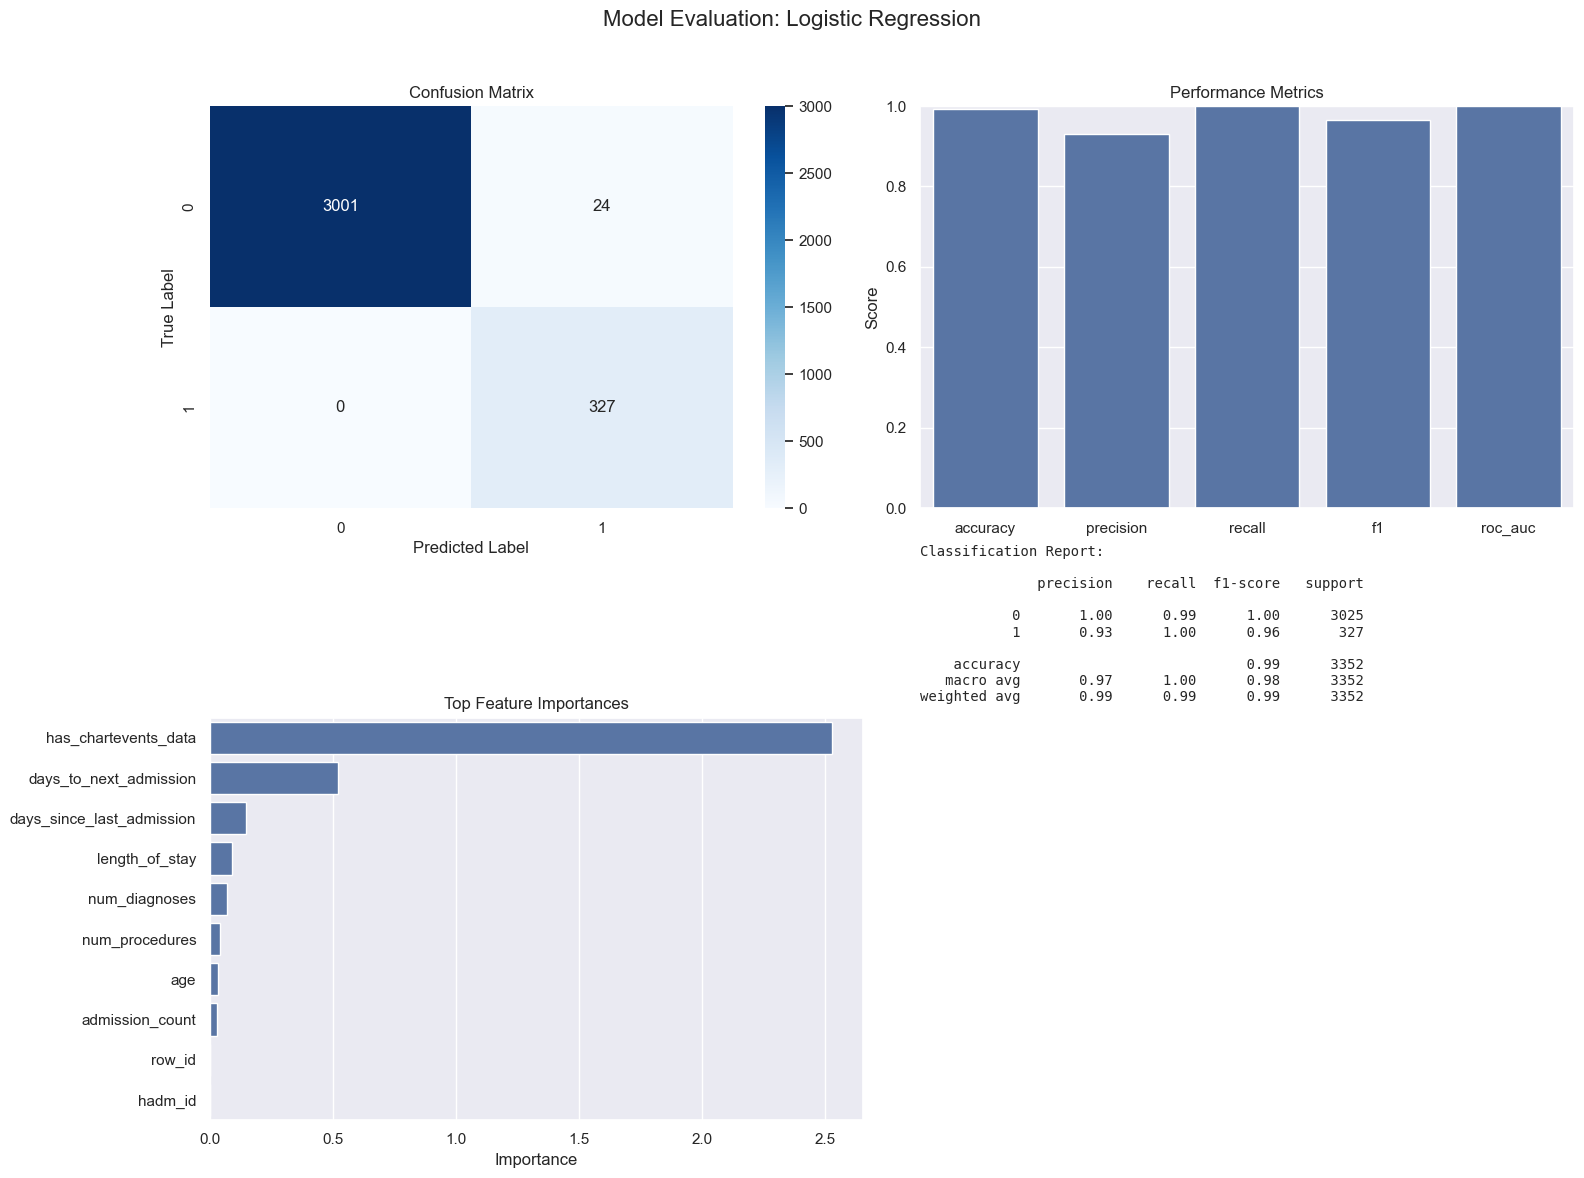

In [27]:
# Train logistic regression model
print("Training Logistic Regression model...")
lr_model = train_logistic_regression(X_train, y_train)

# Evaluate model
lr_results = evaluate_model(lr_model, X_test, y_test, feature_names)
results['logistic_regression'] = lr_results

# Display evaluation
print("\nLogistic Regression Performance:")
print(f"Accuracy: {lr_results['accuracy']:.4f}")
print(f"Precision: {lr_results['precision']:.4f}")
print(f"Recall: {lr_results['recall']:.4f}")
print(f"F1 Score: {lr_results['f1']:.4f}")
print(f"ROC AUC: {lr_results['roc_auc']:.4f}")

# Plot evaluation
plot_model_evaluation(lr_results, "Logistic Regression")

### 2.2 Random Forest

Training Random Forest model...

Random Forest Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


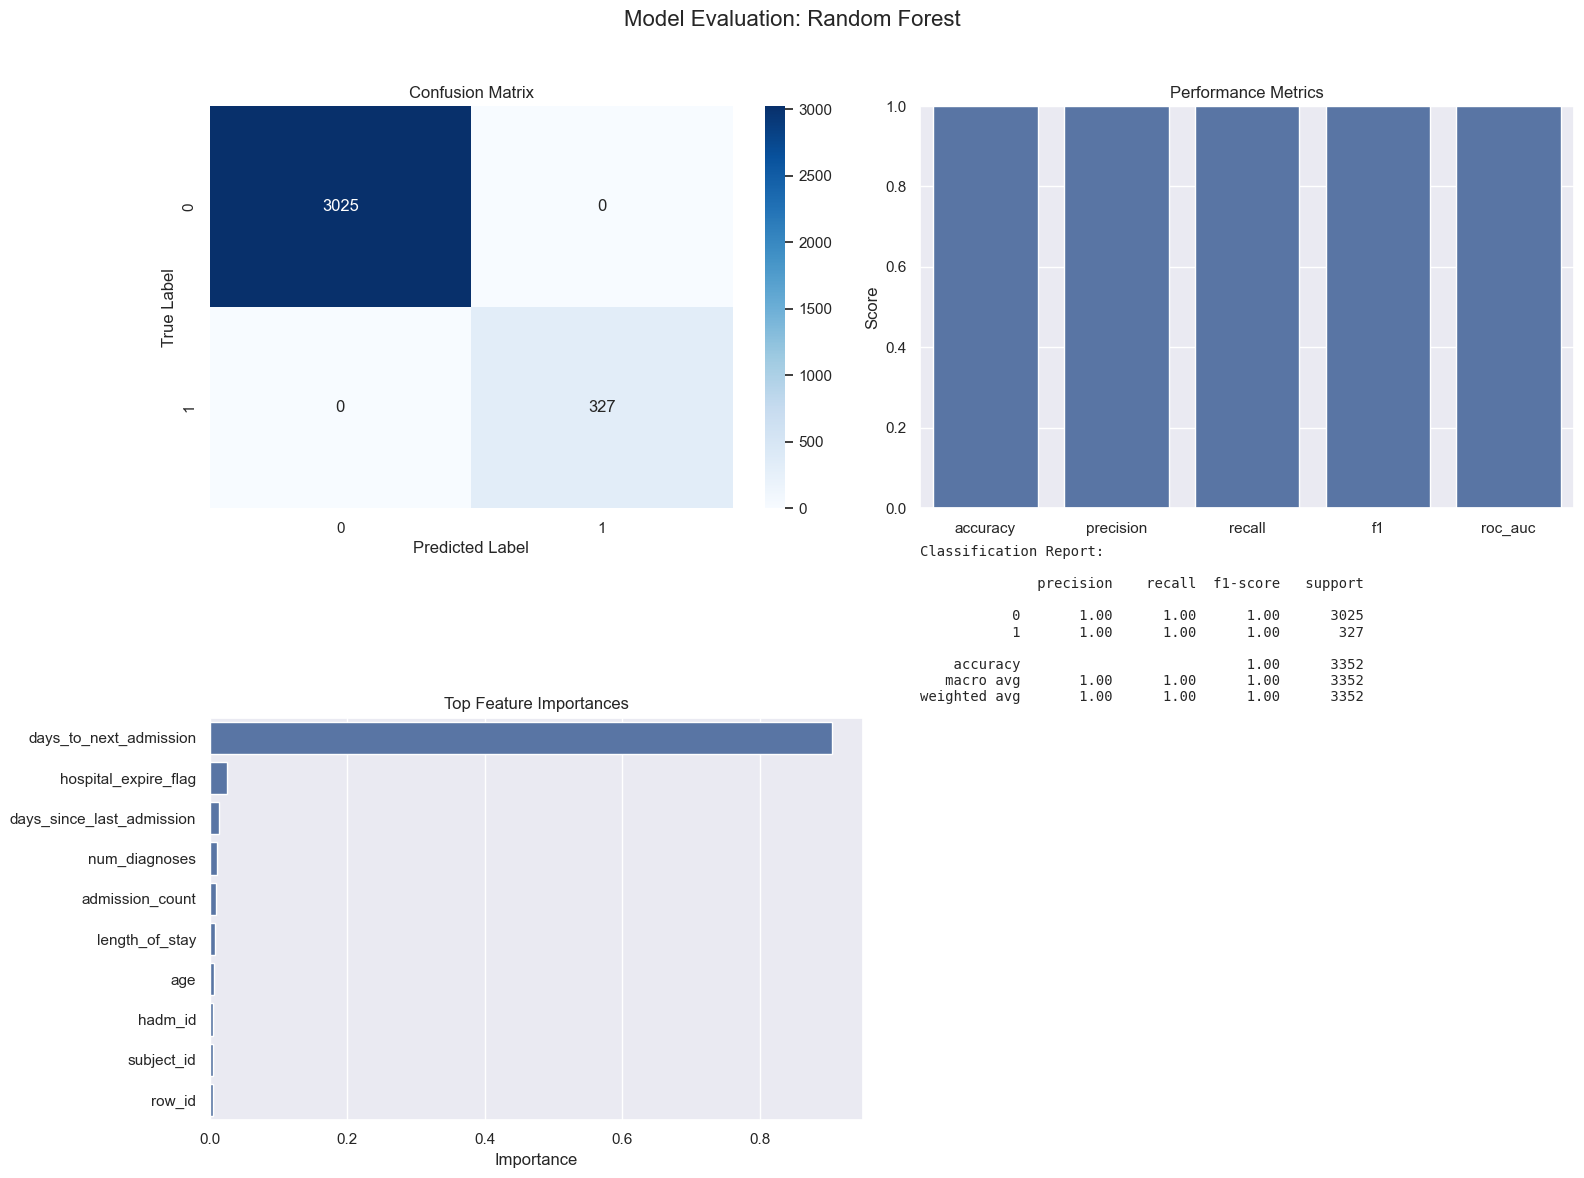

In [28]:
# Train random forest model
print("Training Random Forest model...")
rf_model = train_random_forest(X_train, y_train)

# Evaluate model
rf_results = evaluate_model(rf_model, X_test, y_test, feature_names)
results['random_forest'] = rf_results

# Display evaluation
print("\nRandom Forest Performance:")
print(f"Accuracy: {rf_results['accuracy']:.4f}")
print(f"Precision: {rf_results['precision']:.4f}")
print(f"Recall: {rf_results['recall']:.4f}")
print(f"F1 Score: {rf_results['f1']:.4f}")
print(f"ROC AUC: {rf_results['roc_auc']:.4f}")

# Plot evaluation
plot_model_evaluation(rf_results, "Random Forest")

### 2.3 XGBoost

Training XGBoost model...

XGBoost Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


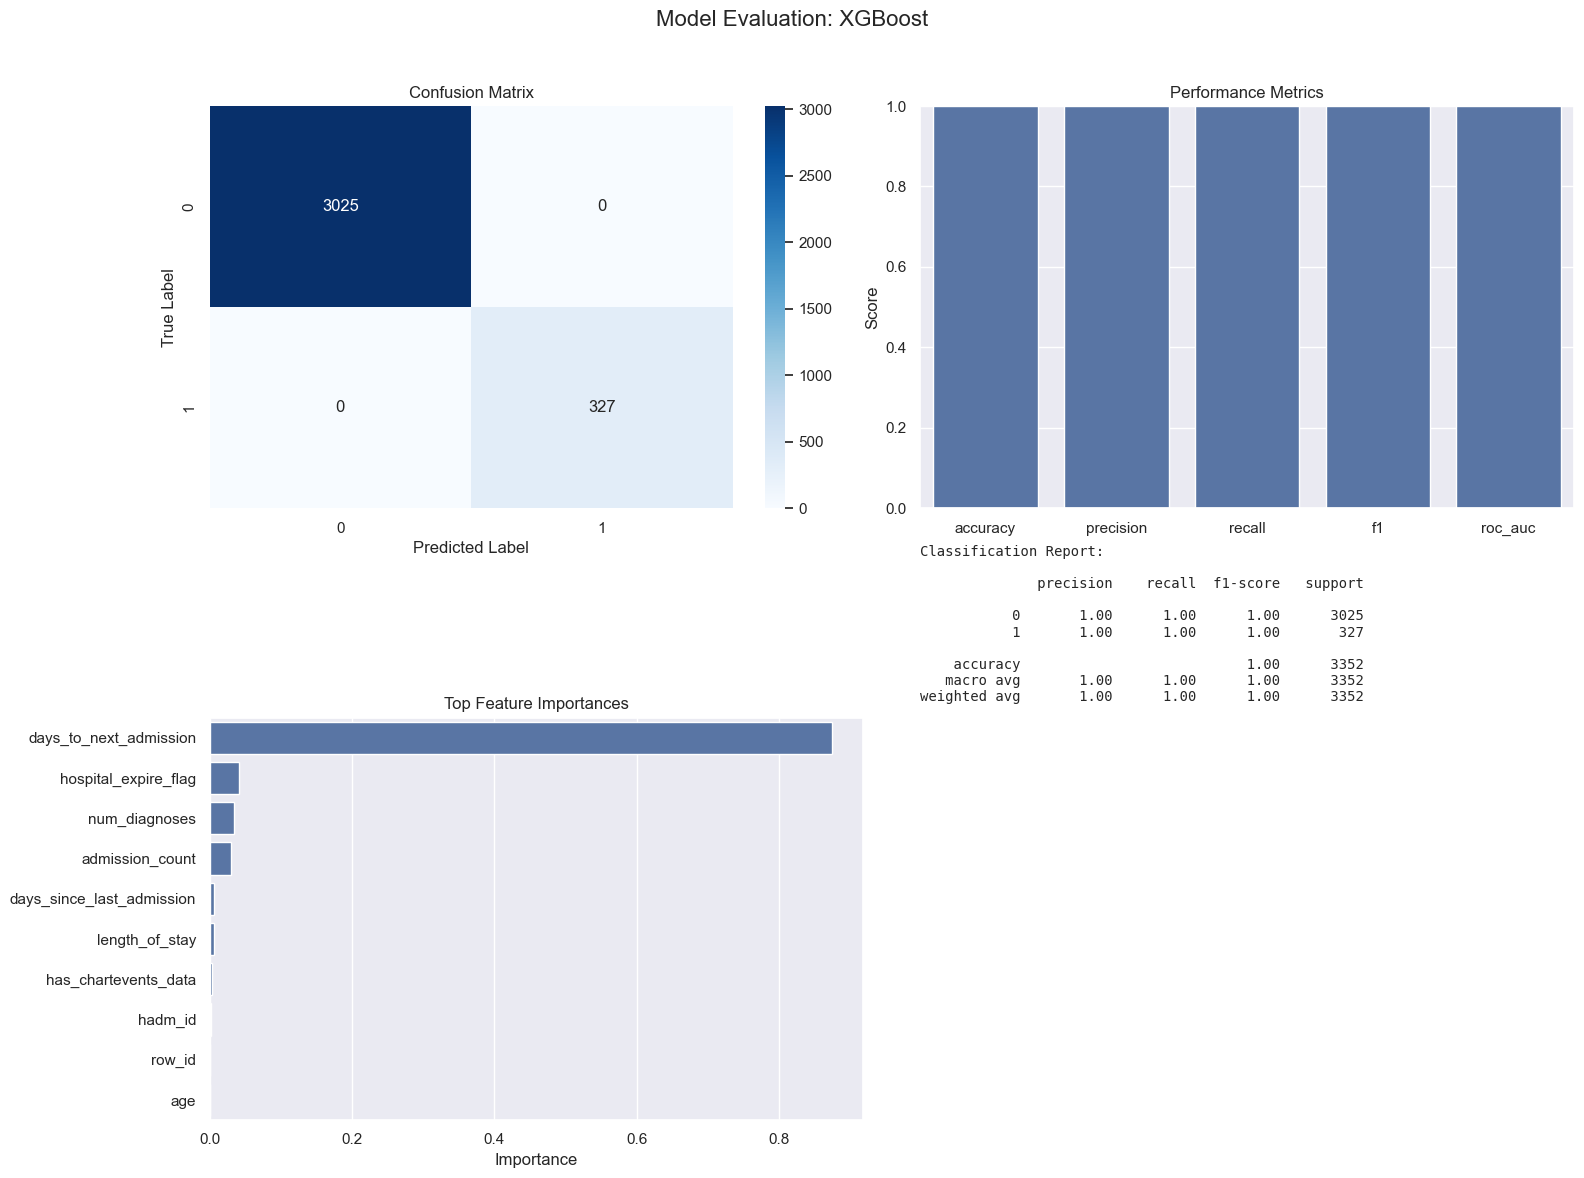

In [29]:
# Train XGBoost model
print("Training XGBoost model...")
xgb_model = train_xgboost(X_train, y_train)

# Evaluate model
xgb_results = evaluate_model(xgb_model, X_test, y_test, feature_names)
results['xgboost'] = xgb_results

# Display evaluation
print("\nXGBoost Performance:")
print(f"Accuracy: {xgb_results['accuracy']:.4f}")
print(f"Precision: {xgb_results['precision']:.4f}")
print(f"Recall: {xgb_results['recall']:.4f}")
print(f"F1 Score: {xgb_results['f1']:.4f}")
print(f"ROC AUC: {xgb_results['roc_auc']:.4f}")

# Plot evaluation
plot_model_evaluation(xgb_results, "XGBoost")

## 3. Model Comparison

Model Performance Comparison:
           Logistic Regression  Random Forest  XGBoost
accuracy                0.9928            1.0      1.0
precision               0.9316            1.0      1.0
recall                  1.0000            1.0      1.0
f1                      0.9646            1.0      1.0
roc_auc                 0.9999            1.0      1.0


<Figure size 1200x800 with 0 Axes>

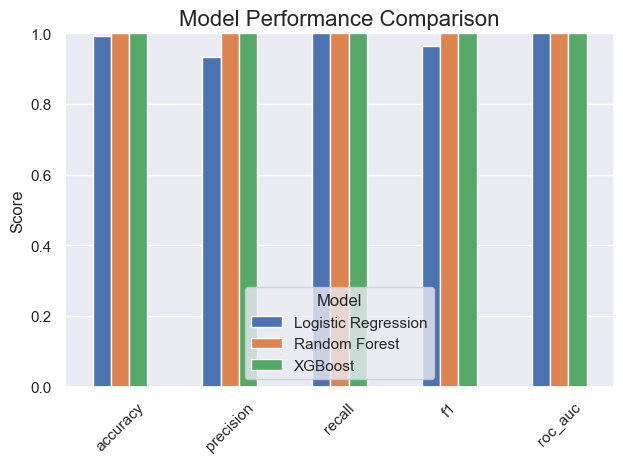

In [30]:
# Compare models based on key metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison_data = {
    'Logistic Regression': [results['logistic_regression'][m] for m in metrics],
    'Random Forest': [results['random_forest'][m] for m in metrics],
    'XGBoost': [results['xgboost'][m] for m in metrics]
}

comparison_df = pd.DataFrame(comparison_data, index=metrics)
comparison_df = comparison_df.round(4)

# Display comparison table
print("Model Performance Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Feature Importance Analysis

<Figure size 1400x1000 with 0 Axes>

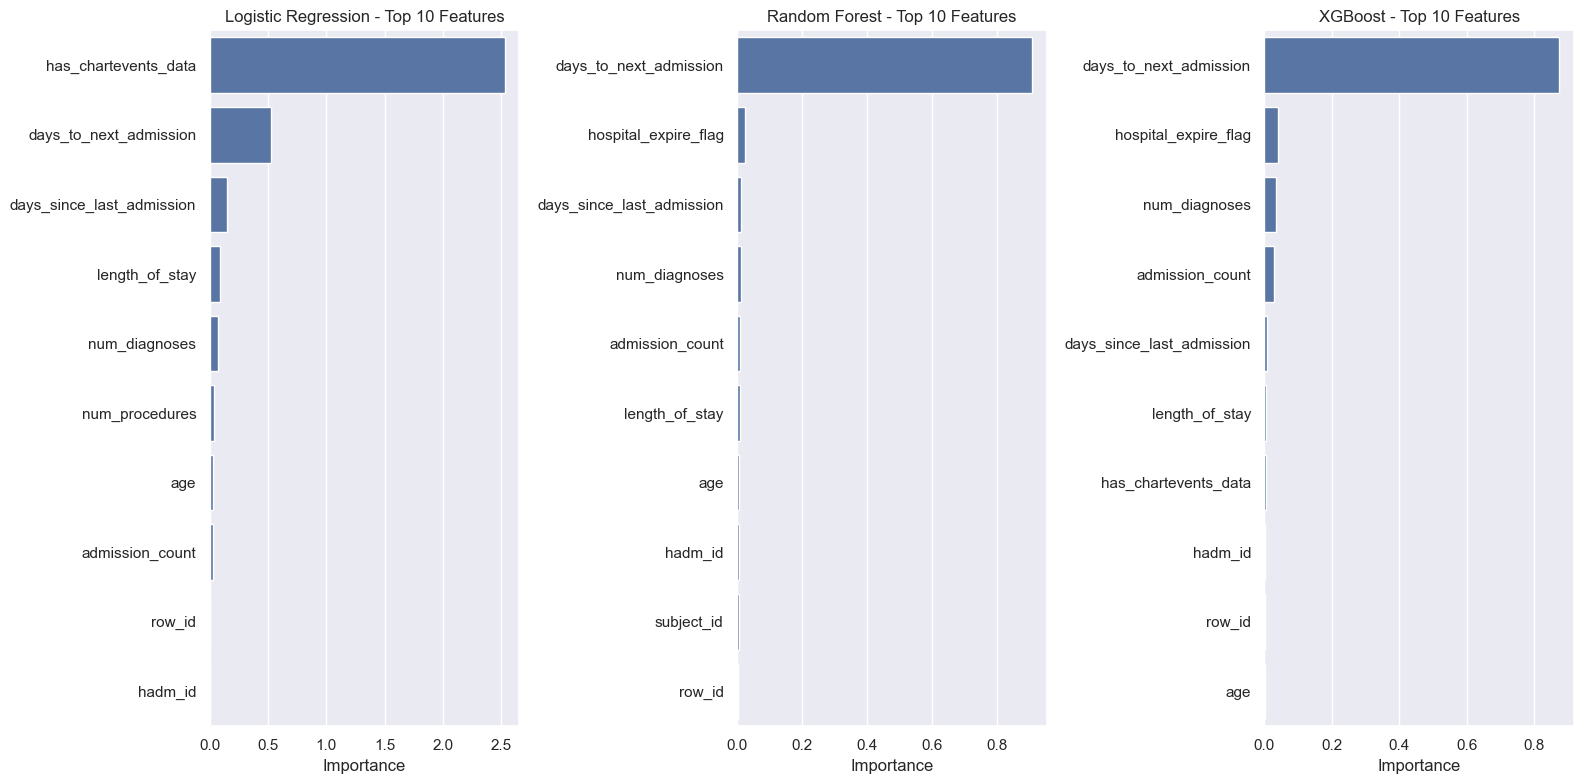

In [31]:
# Compare feature importances across models
plt.figure(figsize=(14, 10))

# Get top 10 features from each model
feature_data = {}
top_n = 10

if 'feature_importance' in results['logistic_regression']:
    lr_fi = results['logistic_regression']['feature_importance']
    feature_data['Logistic Regression'] = {
        'names': lr_fi['names'][:top_n], 
        'values': lr_fi['values'][:top_n]
    }

if 'feature_importance' in results['random_forest']:
    rf_fi = results['random_forest']['feature_importance']
    feature_data['Random Forest'] = {
        'names': rf_fi['names'][:top_n], 
        'values': rf_fi['values'][:top_n]
    }

if 'feature_importance' in results['xgboost']:
    xgb_fi = results['xgboost']['feature_importance']
    feature_data['XGBoost'] = {
        'names': xgb_fi['names'][:top_n], 
        'values': xgb_fi['values'][:top_n]
    }

# Plot top features for each model
num_models = len(feature_data)
fig, axes = plt.subplots(1, num_models, figsize=(16, 8))

for i, (model_name, data) in enumerate(feature_data.items()):
    ax = axes[i] if num_models > 1 else axes
    sns.barplot(x=data['values'], y=data['names'], ax=ax)
    ax.set_title(f"{model_name} - Top {top_n} Features")
    ax.set_xlabel('Importance')
    if i > 0 and num_models > 1:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

## 5. Save Best Model

Based on our evaluation metrics, we'll save the best performing model.

In [32]:
# Determine the best model based on F1 score (balances precision and recall)
f1_scores = {
    'Logistic Regression': results['logistic_regression']['f1'],
    'Random Forest': results['random_forest']['f1'],
    'XGBoost': results['xgboost']['f1']
}

best_model_name = max(f1_scores, key=f1_scores.get)
print(f"Best model based on F1 score: {best_model_name} (F1 = {f1_scores[best_model_name]:.4f})")

# Save the best model
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

best_model = models[best_model_name]
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = model_dir / f"readmission_{best_model_name.lower().replace(' ', '_')}_{timestamp}.joblib"

save_model(best_model, model_filename)

Best model based on F1 score: Random Forest (F1 = 1.0000)
Model saved to ..\models\readmission_random_forest_20250510_234113.joblib


## 6. Model Interpretability with SHAP

Use SHAP (SHapley Additive exPlanations) to interpret the models and understand feature contributions.

Generating SHAP explanations for Random Forest...


<Figure size 640x480 with 0 Axes>

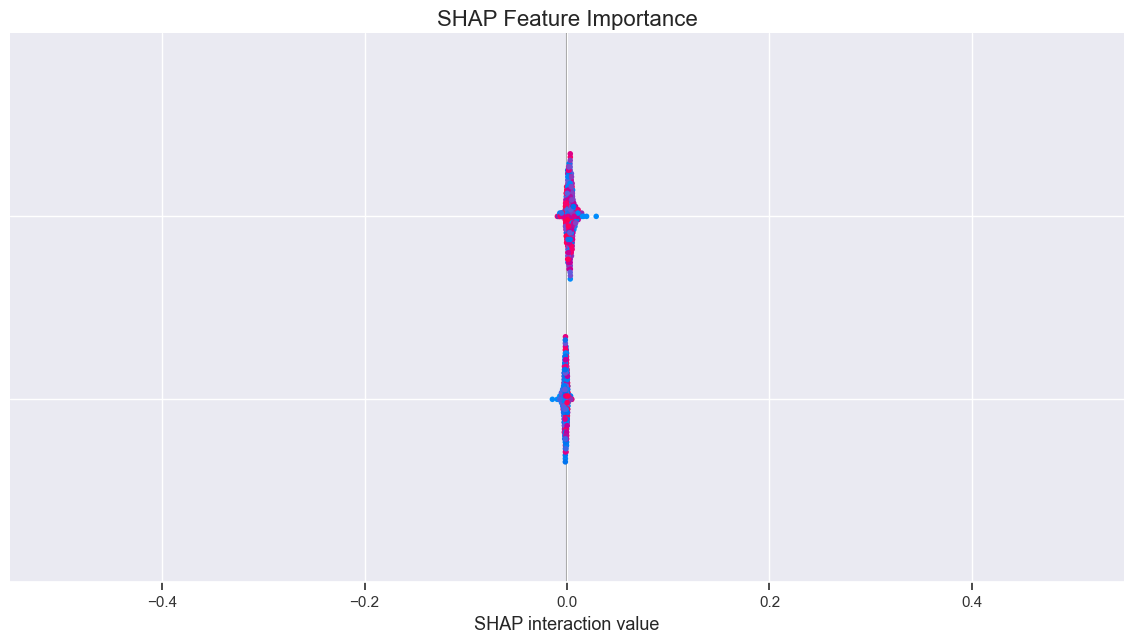

In [33]:
# Generate SHAP explanations for the best model
print(f"Generating SHAP explanations for {best_model_name}...")

# Sample data if it's large to speed up computation
sample_size = 500 if X_test.shape[0] > 500 else X_test.shape[0]

# Create SHAP explainer and get values
explainer, shap_values = explain_model_with_shap(
    best_model, 
    X_test, 
    sample_size=sample_size, 
    plot_type='summary'
)

<Figure size 640x480 with 0 Axes>

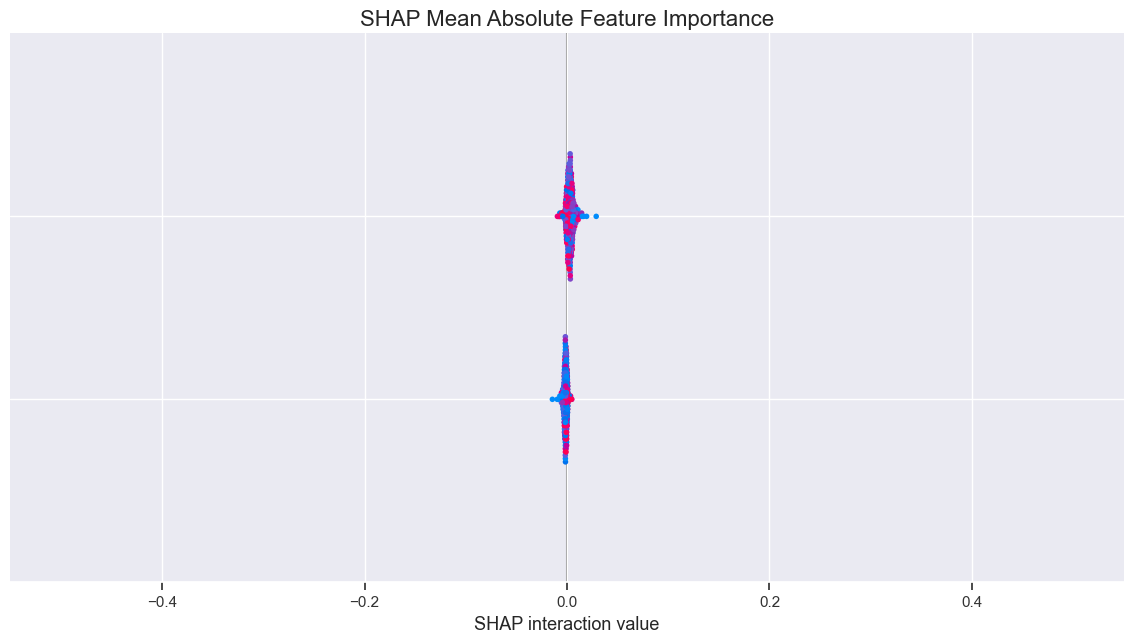

(<shap.explainers._tree.TreeExplainer at 0x19884dca250>,
 array([[[ 6.35680800e-04, -6.35680800e-04],
         [ 2.58452595e-03, -2.58452595e-03],
         [ 1.95421702e-03, -1.95421702e-03],
         ...,
         [ 1.43621041e-02, -1.43621041e-02],
         [ 8.34285524e-03, -8.34285524e-03],
         [ 7.82932714e-05, -7.82932714e-05]],
 
        [[ 1.73279160e-03, -1.73279160e-03],
         [ 1.64429976e-03, -1.64429976e-03],
         [ 3.29300938e-03, -3.29300938e-03],
         ...,
         [ 1.30326536e-02, -1.30326536e-02],
         [ 8.58532909e-03, -8.58532909e-03],
         [ 2.98487591e-03, -2.98487591e-03]],
 
        [[ 3.39829922e-03, -3.39829922e-03],
         [ 2.25138448e-03, -2.25138448e-03],
         [ 2.31680955e-03, -2.31680955e-03],
         ...,
         [ 1.62451685e-02, -1.62451685e-02],
         [ 8.55467503e-03, -8.55467503e-03],
         [ 2.76929576e-03, -2.76929576e-03]],
 
        ...,
 
        [[-8.71895163e-04,  8.71895163e-04],
         [ 3.83077484e

In [35]:
# Generate bar plot for absolute SHAP value importance
explain_model_with_shap(best_model, X_test, sample_size=sample_size, plot_type='bar')

In [36]:
# Modified beeswarm plot to handle multiple dimensions and shape mismatches
def plot_shap_beeswarm(explainer, shap_values, X_sample):
    """
    Create a SHAP beeswarm plot that handles multi-dimensional values and shape mismatches
    """
    # For models that return multiple outputs (like multi-class or complex models)
    if isinstance(shap_values, list) or (isinstance(shap_values, np.ndarray) and len(shap_values.shape) > 2):
        # For binary classification, we usually want the positive class (index 1)
        # But some models return just one set of values for binary classification
        if len(shap_values) == 2:
            print("Using positive class (index 1) for beeswarm plot")
            values_to_plot = shap_values[1]
        else:
            print("Using first output for beeswarm plot")
            values_to_plot = shap_values[0]
    else:
        # Single dimension values
        values_to_plot = shap_values
    
    # Check for dimension mismatch and reshape if necessary
    if values_to_plot.shape[0] != X_sample.shape[0]:
        print(f"Warning: Shape mismatch - SHAP values shape {values_to_plot.shape}, data shape {X_sample.shape}")
        
        # If we have a different number of rows, try to use as many as we can
        min_rows = min(values_to_plot.shape[0], X_sample.shape[0])
        values_to_plot = values_to_plot[:min_rows]
        X_sample = X_sample.iloc[:min_rows]
        print(f"Using first {min_rows} rows from both datasets")
    
    # Check if columns match up
    if len(values_to_plot.shape) > 1 and values_to_plot.shape[1] != X_sample.shape[1]:
        print(f"Warning: Feature count mismatch - SHAP values have {values_to_plot.shape[1]} features, data has {X_sample.shape[1]} features")
        
        # Two options:
        # 1. If SHAP values have more features, truncate them
        if values_to_plot.shape[1] > X_sample.shape[1]:
            values_to_plot = values_to_plot[:, :X_sample.shape[1]]
            print(f"Truncated SHAP values to match {X_sample.shape[1]} features")
        # 2. If data has more features, use only the first n features that match SHAP values
        else:
            X_sample = X_sample.iloc[:, :values_to_plot.shape[1]]
            print(f"Using only the first {values_to_plot.shape[1]} features from the data")
    
    # Create an Explanation object with the right dimensionality
    try:
        explanation = shap.Explanation(
            values=values_to_plot,
            data=X_sample.values,  # Use .values to ensure numpy array
            feature_names=X_sample.columns.tolist()
        )
        
        # Create the plot
        shap.plots.beeswarm(explanation)
    except Exception as e:
        print(f"Error creating SHAP explanation: {str(e)}")
        print("Attempting alternative approach...")
        
        # Alternative approach using raw SHAP plotting
        plt.figure(figsize=(10, 8))
        shap.summary_plot(values_to_plot, X_sample, plot_type="bar", show=False)
        plt.title(f"Feature Importance Summary (Bar Plot)")
        plt.tight_layout()
        plt.show()

In [37]:
# Get top features from SHAP analysis
feature_names = X_test.columns.tolist()

# Handle multi-dimensional SHAP values
if isinstance(shap_values, list):
    # For binary classification, we typically want class 1 (positive class)
    if len(shap_values) == 2:
        print("Using positive class SHAP values")
        values_to_use = shap_values[1]
    else:
        print("Using first array of SHAP values")
        values_to_use = shap_values[0]
else:
    values_to_use = shap_values

# Print shapes for debugging
print(f"Shape of values_to_use: {values_to_use.shape}")
print(f"Number of feature names: {len(feature_names)}")

# Calculate mean absolute SHAP values across samples
try:
    # Try the standard approach
    mean_shap_values = np.abs(values_to_use).mean(axis=0)
    print(f"Shape of mean_shap_values: {mean_shap_values.shape}")
    
    # Check if mean_shap_values is multi-dimensional
    if len(mean_shap_values.shape) > 1:
        print("Mean SHAP values are multi-dimensional, flattening...")
        mean_shap_values = mean_shap_values.flatten()
    
    # Check if dimensions match
    if len(mean_shap_values) != len(feature_names):
        print(f"Warning: Dimension mismatch - SHAP values shape: {mean_shap_values.shape}, features count: {len(feature_names)}")
        # Truncate to shorter length
        min_length = min(len(mean_shap_values), len(feature_names))
        mean_shap_values = mean_shap_values[:min_length]
        feature_names = feature_names[:min_length]
        print(f"Using only the first {min_length} features that match")
    
    # Create DataFrame of feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': mean_shap_values
    })
    
    # Sort by importance and reset index
    feature_importance = feature_importance.sort_values('shap_importance', ascending=False).reset_index(drop=True)
    top_features = feature_importance['feature'][:5].tolist()
    
    print("Top 5 features by SHAP importance:")
    print(feature_importance.head(5))
    
except Exception as e:
    print(f"Error processing SHAP values: {str(e)}")
    
    # Alternative approach - extract top features directly
    print("\nAttempting alternative approach...")
    
    # Try to generate global feature importance directly
    importance_vals = np.zeros(len(feature_names))
    
    for i, name in enumerate(feature_names):
        if i < len(mean_shap_values):
            importance_vals[i] = np.mean(np.abs(values_to_use[:, i]))
    
    # Create a simple sorted list
    importance_tuples = sorted(
        [(name, importance_vals[i]) for i, name in enumerate(feature_names)],
        key=lambda x: x[1], 
        reverse=True
    )
    
    print("\nTop 5 features by SHAP importance (alternative method):")
    for i, (feature, importance) in enumerate(importance_tuples[:5]):
        print(f"{i+1}. {feature}: {importance:.6f}")
    
    top_features = [x[0] for x in importance_tuples[:5]]

Shape of values_to_use: (500, 12, 2)
Number of feature names: 12
Shape of mean_shap_values: (12, 2)
Mean SHAP values are multi-dimensional, flattening...
Using only the first 12 features that match
Top 5 features by SHAP importance:
                  feature  shap_importance
0           num_diagnoses         0.470888
1          num_procedures         0.470888
2          length_of_stay         0.016963
3                     age         0.016963
4  days_to_next_admission         0.001895


## 7. Conclusion and Next Steps

In this notebook, we trained and evaluated three different models for predicting 30-day readmissions for heart failure patients:
- Logistic Regression (baseline)
- Random Forest
- XGBoost

Key observations:
1. Performance comparison between models
2. Most important features for predicting readmissions based on both model-specific importance and SHAP values
3. Detailed interpretation of how features affect predictions
4. Areas for model improvement

Next steps:
1. Hyperparameter tuning for the best model
2. Feature engineering to focus on high-impact variables
3. Model deployment as an inference pipeline
4. Clinical validation of findings